# Signal Returns — Last 6 Months
For each trading day in the past 6 months, computes:
- Composite score and quintile
- Implied trade direction (steepener / flattener)
- 5-day forward return on 2s10s
- Aligned return (P&L if you traded in the direction the model implied)
- Hit / miss

In [74]:
import sys
sys.path.insert(0, '..')

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Always reload src modules so that re-running this cell picks up
# any changes made to the Python source without restarting the kernel.
import src.data.return_calculator
import src.data.data_loader
import src.features.feature_engineering
import src.signals.signal_engine

importlib.reload(src.data.return_calculator)
importlib.reload(src.data.data_loader)
importlib.reload(src.features.feature_engineering)
importlib.reload(src.signals.signal_engine)

from src.data.data_loader import DataLoader
from src.features.feature_engineering import FeatureEngineer
from src.signals.signal_engine import SignalEngine

FRED_KEY = '6871fa0076eb56b3be3858cb458a9bba'
HORIZON  = 5   # trading days

loader = DataLoader(FRED_KEY)
df     = loader.load_treasury_data()
df     = FeatureEngineer.add_curve_features(df)
df['composite_score'] = SignalEngine.composite_score(df)
df['gated_score']     = SignalEngine.gated_score(df)

print(f'Full dataset: {df.index[0].date()} → {df.index[-1].date()}  ({len(df)} trading days)')

Full dataset: 2018-04-03 → 2026-02-20  (1969 trading days)


In [59]:
# ── Restrict to last 6 months ────────────────────────────────────────────────
cutoff = df.index.max() - pd.DateOffset(months=6)
window = df[df.index >= cutoff].copy()
print(f'6-month window: {window.index[0].date()} → {window.index[-1].date()}  ({len(window)} trading days)')

6-month window: 2025-08-20 → 2026-02-20  (125 trading days)


In [60]:
# ── Quintile thresholds (full history — same as the live model) ──────────────
q_cuts = df['composite_score'].quantile([0.2, 0.4, 0.6, 0.8])

def assign_quintile(score):
    if score <= q_cuts[0.2]: return 'Q1'
    elif score <= q_cuts[0.4]: return 'Q2'
    elif score <= q_cuts[0.6]: return 'Q3'
    elif score <= q_cuts[0.8]: return 'Q4'
    else: return 'Q5'

def signal_direction(score):
    if score >= 1.0:  return 'steepener'
    elif score <= -1.0: return 'flattener'
    return 'neutral'

print(f'Q1 threshold: score < {q_cuts[0.2]:+.2f}')
print(f'Q5 threshold: score > {q_cuts[0.8]:+.2f}')

Q1 threshold: score < -1.24
Q5 threshold: score > +1.31


In [61]:
# ── Build signal returns table ───────────────────────────────────────────────
# Forward return: 2s10s(t + horizon) - 2s10s(t), in bps
spread = df['2s10s'].copy()
fwd_return_bps = spread.diff(HORIZON).shift(-HORIZON) * 100  # shift back so t=entry date

rows = []
for date, row in window.iterrows():
    score     = float(row['composite_score'])
    gated     = float(row['gated_score'])
    quintile  = assign_quintile(score)
    direction = signal_direction(score)
    fwd_bps   = fwd_return_bps.get(date, np.nan)

    sign = {'steepener': +1, 'flattener': -1, 'neutral': 0}.get(direction, 0)
    aligned_bps = fwd_bps * sign if pd.notna(fwd_bps) else np.nan
    hit = (1 if aligned_bps > 0 else 0) if pd.notna(aligned_bps) and sign != 0 else np.nan

    rows.append({
        'date':            date.date(),
        'composite_score': round(score, 2),
        'gated_score':     round(gated, 2),
        'quintile':        quintile,
        'direction':       direction,
        'curve_regime':    row.get('regime', 'Unknown'),
        'macro_regime':    row.get('macro_regime', 'N/A'),
        '2s10s_bps':       round(float(row['2s10s']) * 100, 1),
        '2s10s_z20':       round(float(row.get('2s10s_z20', np.nan)), 2),
        'VIX':             round(float(row.get('VIX', np.nan)), 1),
        f'fwd_{HORIZON}d_bps':  round(fwd_bps, 2) if pd.notna(fwd_bps) else np.nan,
        'aligned_bps':     round(aligned_bps, 2) if pd.notna(aligned_bps) else np.nan,
        'hit':             hit,
    })

results = pd.DataFrame(rows).set_index('date')
print(f'Total rows: {len(results)}  |  Resolved: {results["aligned_bps"].notna().sum()}  |  Pending: {results["aligned_bps"].isna().sum()}')
results.tail(10)

Total rows: 125  |  Resolved: 120  |  Pending: 5


,composite_score,gated_score,quintile,direction,curve_regime,macro_regime,2s10s_bps,2s10s_z20,VIX,fwd_5d_bps,aligned_bps,hit
date,,,,,,,,,,,,
2026-02-06,1.68,1.68,Q5,steepener,Bull Flattener,Neutral,72.0,0.99,17.8,-8.0,-8.0,0.0
2026-02-09,-1.24,-1.24,Q2,flattener,Bull Steepener,Neutral,74.0,1.34,17.4,-12.0,12.0,1.0
2026-02-10,1.78,1.78,Q5,steepener,Bull Flattener,Neutral,71.0,0.53,17.8,-9.0,-9.0,0.0
2026-02-11,1.97,1.97,Q5,steepener,Bull Flattener,Neutral,66.0,-0.75,17.6,-5.0,-5.0,0.0
2026-02-12,1.89,1.89,Q5,steepener,Bull Flattener,Neutral,62.0,-1.68,20.8,-2.0,-2.0,0.0
2026-02-13,0.47,0.47,Q3,neutral,Bull Flattener,Neutral,64.0,-1.31,20.6,NaN,NaN,NaN
2026-02-17,0.99,0.99,Q4,neutral,Bull Flattener,Neutral,62.0,-1.69,20.3,NaN,NaN,NaN
2026-02-18,0.64,0.64,Q4,neutral,Bull Flattener,Neutral,62.0,-1.50,19.6,NaN,NaN,NaN
2026-02-19,0.93,0.93,Q4,neutral,Bull Flattener,Neutral,61.0,-1.57,20.2,NaN,NaN,NaN


In [62]:
# ── Full table (resolved signals only) ───────────────────────────────────────
resolved = results[results['aligned_bps'].notna()].copy()

# Colour hit/miss for readability
def colour_hit(val):
    if val == 1:   return 'background-color: #1a3a1a; color: #66ff66'
    elif val == 0: return 'background-color: #3a1a1a; color: #ff6666'
    return ''

def colour_bps(val):
    if pd.isna(val): return ''
    return 'color: #66ff66' if val > 0 else ('color: #ff6666' if val < 0 else '')

resolved.style \
    .applymap(colour_hit, subset=['hit']) \
    .applymap(colour_bps, subset=['aligned_bps', f'fwd_{HORIZON}d_bps']) \
    .format({
        'composite_score': '{:+.2f}',
        'gated_score':     '{:+.2f}',
        '2s10s_bps':       '{:+.1f}',
        '2s10s_z20':       '{:+.2f}',
        f'fwd_{HORIZON}d_bps': '{:+.2f}',
        'aligned_bps':     '{:+.2f}',
        'hit':             lambda v: '✓' if v == 1 else ('✗' if v == 0 else '─'),
    })

/var/folders/zh/8x6bgqps2zj8yvb5jq9tqt3h0000gn/T/ipykernel_70437/46294528.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  resolved.style \


,composite_score,gated_score,quintile,direction,curve_regime,macro_regime,2s10s_bps,2s10s_z20,VIX,fwd_5d_bps,aligned_bps,hit
date,,,,,,,,,,,,
2025-08-20,+1.36,+1.36,Q5,steepener,Bear Flattener,Neutral,+55.0,+0.68,15.700000,+10.00,+10.00,✓
2025-08-21,+1.77,+1.77,Q5,steepener,Bear Flattener,Neutral,+54.0,+0.41,16.600000,+6.00,+6.00,✓
2025-08-22,-0.51,-0.51,Q2,neutral,Bull Flattener,Neutral,+58.0,+1.24,14.200000,+6.00,+0.00,─
2025-08-25,+1.62,+1.62,Q5,steepener,Bull Flattener,Neutral,+55.0,+0.48,14.800000,+7.00,+7.00,✓
2025-08-26,-3.44,-3.44,Q1,flattener,Bull Steepener,Neutral,+65.0,+2.30,14.600000,-4.00,+4.00,✓
2025-08-27,-2.35,-2.35,Q1,flattener,Bull Steepener,Neutral,+65.0,+2.07,14.800000,-7.00,+7.00,✓
2025-08-28,-1.63,-1.63,Q1,flattener,Bull Steepener,Neutral,+60.0,+1.03,14.400000,-1.00,+1.00,✓
2025-08-29,-2.47,-2.47,Q1,flattener,Bull Steepener,Neutral,+64.0,+1.72,15.400000,-8.00,+8.00,✓
2025-09-02,+0.56,+0.56,Q4,neutral,Bull Steepener,Neutral,+62.0,+1.15,17.200000,-8.00,-0.00,─


In [63]:
# ── Performance summary ───────────────────────────────────────────────────────
directional = resolved[resolved['direction'] != 'neutral'].copy()

def sharpe(s):
    return s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan

summary = pd.Series({
    'total_signals':      len(resolved),
    'directional':        len(directional),
    'hit_rate':           round(directional['hit'].mean(), 3),
    'mean_aligned_bps':   round(directional['aligned_bps'].mean(), 2),
    'median_aligned_bps': round(directional['aligned_bps'].median(), 2),
    'sharpe_ann':         round(sharpe(directional['aligned_bps']), 3),
    'cumulative_pnl_bps': round(directional['aligned_bps'].sum(), 2),
    'best_trade_bps':     round(directional['aligned_bps'].max(), 2),
    'worst_trade_bps':    round(directional['aligned_bps'].min(), 2),
}, name='6-month in-sample')

print(summary.to_string())

total_signals         120.000
directional            65.000
hit_rate                0.615
mean_aligned_bps        0.720
median_aligned_bps      1.000
sharpe_ann              1.006
cumulative_pnl_bps     47.000
best_trade_bps         12.000
worst_trade_bps       -11.000


In [64]:
# ── Performance by quintile ───────────────────────────────────────────────────
by_q = directional.groupby('quintile')['aligned_bps'].agg(
    count='count',
    hit_rate=lambda x: (x > 0).mean(),
    mean_bps='mean',
    sharpe=sharpe,
).round(3)

by_q.style \
    .background_gradient(subset=['hit_rate'], cmap='RdYlGn', vmin=0.3, vmax=0.8) \
    .background_gradient(subset=['mean_bps'], cmap='RdYlGn') \
    .format({'hit_rate': '{:.1%}', 'mean_bps': '{:+.2f}', 'sharpe': '{:.2f}'})

,count,hit_rate,mean_bps,sharpe
quintile,,,,
Q1,17,52.9%,+0.59,0.99
Q2,6,66.7%,+1.50,1.72
Q4,6,83.3%,+2.17,5.52
Q5,36,58.3%,+0.42,0.52


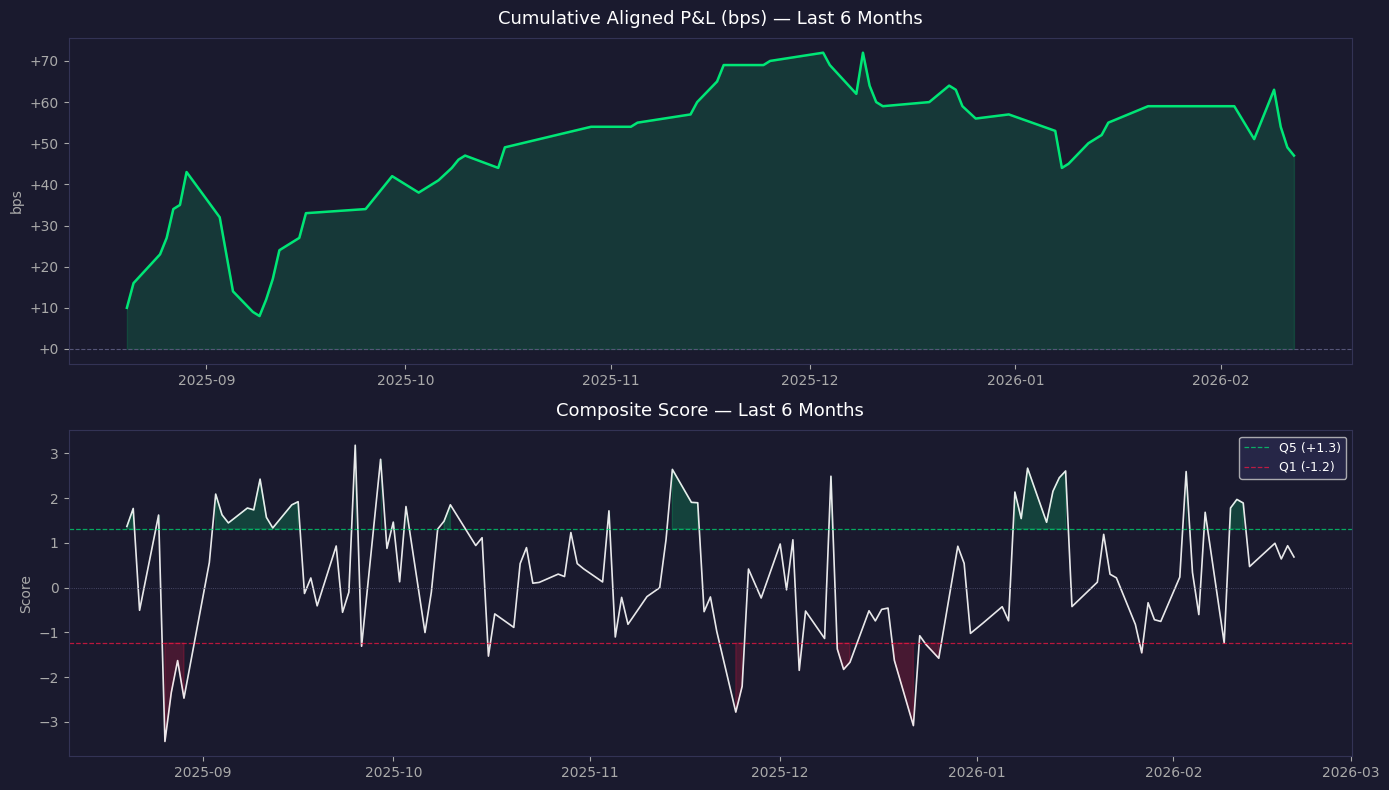

In [65]:
# ── Cumulative P&L chart (directional signals only) ───────────────────────────
cum_pnl = directional['aligned_bps'].cumsum()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), facecolor='#1a1a2e')
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

# Top: cumulative P&L
ax1 = axes[0]
ax1.plot(pd.to_datetime(cum_pnl.index), cum_pnl.values, color='#00e676', linewidth=1.8)
ax1.axhline(0, color='#555577', linewidth=0.8, linestyle='--')
ax1.fill_between(pd.to_datetime(cum_pnl.index), cum_pnl.values, 0,
                 where=cum_pnl.values >= 0, alpha=0.15, color='#00e676')
ax1.fill_between(pd.to_datetime(cum_pnl.index), cum_pnl.values, 0,
                 where=cum_pnl.values < 0, alpha=0.15, color='#ff1744')
ax1.set_title('Cumulative Aligned P&L (bps) — Last 6 Months', color='white', fontsize=13, pad=10)
ax1.set_ylabel('bps', color='#aaaaaa')
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.0f'))

# Bottom: composite score with Q1/Q5 bands
ax2 = axes[1]
score_series = window['composite_score']
ax2.plot(score_series.index, score_series.values, color='white', linewidth=1.2, alpha=0.9)
ax2.axhline(q_cuts[0.8], color='#00e676', linewidth=0.9, linestyle='--', alpha=0.7, label=f'Q5 ({q_cuts[0.8]:+.1f})')
ax2.axhline(q_cuts[0.2], color='#ff1744', linewidth=0.9, linestyle='--', alpha=0.7, label=f'Q1 ({q_cuts[0.2]:+.1f})')
ax2.axhline(0, color='#555577', linewidth=0.6, linestyle=':')
ax2.fill_between(score_series.index, score_series.values, q_cuts[0.8],
                 where=score_series.values >= q_cuts[0.8], alpha=0.2, color='#00e676')
ax2.fill_between(score_series.index, score_series.values, q_cuts[0.2],
                 where=score_series.values <= q_cuts[0.2], alpha=0.2, color='#ff1744')
ax2.set_title('Composite Score — Last 6 Months', color='white', fontsize=13, pad=10)
ax2.set_ylabel('Score', color='#aaaaaa')
ax2.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)

plt.tight_layout()
plt.show()

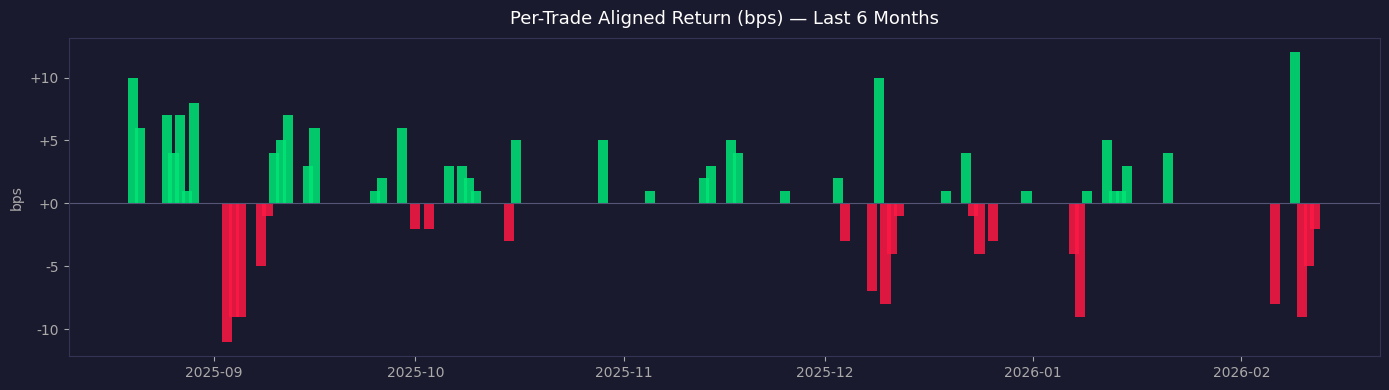

In [66]:
# ── Per-trade bar chart ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 4), facecolor='#1a1a2e')
ax.set_facecolor('#1a1a2e')
ax.tick_params(colors='#aaaaaa')
ax.spines[:].set_color('#333355')

dates  = pd.to_datetime(directional.index)
values = directional['aligned_bps'].values
colors = ['#00e676' if v > 0 else '#ff1744' for v in values]

ax.bar(dates, values, color=colors, width=1.5, alpha=0.85)
ax.axhline(0, color='#555577', linewidth=0.8)
ax.set_title('Per-Trade Aligned Return (bps) — Last 6 Months', color='white', fontsize=13, pad=10)
ax.set_ylabel('bps', color='#aaaaaa')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.0f'))

plt.tight_layout()
plt.show()

In [67]:
# ── Monthly breakdown ─────────────────────────────────────────────────────────
directional_dt = directional.copy()
directional_dt.index = pd.to_datetime(directional_dt.index)

monthly = directional_dt.resample('ME').agg(
    trades=('aligned_bps', 'count'),
    hit_rate=('hit', 'mean'),
    total_bps=('aligned_bps', 'sum'),
    mean_bps=('aligned_bps', 'mean'),
).round(3)
monthly.index = monthly.index.strftime('%b %Y')

monthly.style \
    .background_gradient(subset=['total_bps'], cmap='RdYlGn') \
    .background_gradient(subset=['hit_rate'],  cmap='RdYlGn', vmin=0.3, vmax=0.8) \
    .format({'hit_rate': '{:.1%}', 'total_bps': '{:+.1f}', 'mean_bps': '{:+.2f}'})

,trades,hit_rate,total_bps,mean_bps
date,,,,
Aug 2025,7,100.0%,+43.0,+6.14
Sep 2025,13,61.5%,-1.0,-0.08
Oct 2025,9,66.7%,+12.0,+1.33
Nov 2025,8,87.5%,+16.0,+2.00
Dec 2025,13,38.5%,-13.0,-1.00
Jan 2026,9,66.7%,+2.0,+0.22
Feb 2026,6,16.7%,-12.0,-2.00


---
## DV01-Weighted P&L (Position Sizing)

Compares three sizing approaches on the same signals:

| Approach | Position size |
|----------|--------------|
| **Equal-weight** | Full \$100k DV01 on every Q5/Q1 signal |
| **Score-only** | \$100k × (|score| / 4) — more conviction = bigger |
| **Vol-adjusted** | \$100k × (|score| / 4) × (10bps / fwd_vol) — also sizes down in high-vol |

Dollar P&L per trade = DV01 × aligned_bps. Shown normalised to \$100k max DV01.

In [68]:
# ── Compute sizing for every day in the window ───────────────────────────────
MAX_DV01        = 100_000   # reference max DV01 ($100k/bp)
TARGET_RISK_BPS = 10.0      # target bps at risk per trade at max vol-adj size

sizing_full = SignalEngine.position_size(
    df,
    max_dv01=MAX_DV01,
    target_risk_bps=TARGET_RISK_BPS,
    horizon=HORIZON,
)

sizing_win = sizing_full.loc[window.index].copy()

# Join with forward returns computed in results
sizing_win['aligned_bps']   = results['aligned_bps']
sizing_win['direction_res'] = results['direction']

# Keep only resolved signals with a directional trade
sz = sizing_win[
    (sizing_win['aligned_bps'].notna()) &
    (sizing_win['direction'] != 'flat')
].copy()

# ── Three sizing approaches (DV01 as fraction of MAX_DV01) ───────────────────
sz['dv01_equal']     = 1.0                                      # always full size
sz['dv01_score']     = sz['score_fraction']                     # score-scaled only
sz['dv01_voladj']    = (sz['score_fraction'] * sz['vol_scalar']).clip(upper=1.5)  # vol-adjusted

# Weighted bps (= fraction × aligned_bps; multiply by MAX_DV01 for dollar P&L)
sz['pnl_equal_bps']  = sz['dv01_equal']   * sz['aligned_bps']
sz['pnl_score_bps']  = sz['dv01_score']   * sz['aligned_bps']
sz['pnl_voladj_bps'] = sz['dv01_voladj']  * sz['aligned_bps']

print(f'Directional signals with resolved returns: {len(sz)}')
print()

# ── Summary statistics ────────────────────────────────────────────────────────
def stats(s, label):
    ann_sharpe = s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan
    max_dd     = (s.cumsum() - s.cumsum().cummax()).min()
    return pd.Series({
        'total_bps':  round(s.sum(), 1),
        'mean_bps':   round(s.mean(), 2),
        'hit_rate':   round((s > 0).mean(), 3),
        'sharpe':     round(ann_sharpe, 3),
        'max_dd_bps': round(max_dd, 1),
        'best':       round(s.max(), 1),
        'worst':      round(s.min(), 1),
    }, name=label)

comparison = pd.DataFrame([
    stats(sz['pnl_equal_bps'],  'Equal-weight  (full DV01 always)'),
    stats(sz['pnl_score_bps'],  'Score-only    (scaled by |score|/4)'),
    stats(sz['pnl_voladj_bps'], 'Vol-adjusted  (score × vol scalar)'),
])

print(comparison.to_string())

Directional signals with resolved returns: 53

                                     total_bps  mean_bps  hit_rate  sharpe  max_dd_bps  best  worst
Equal-weight  (full DV01 always)          32.0      0.60     0.585   0.825       -37.0  10.0  -11.0
Score-only    (scaled by |score|/4)       23.9      0.45     0.585   1.292       -15.3   6.2   -5.7
Vol-adjusted  (score × vol scalar)        34.2      0.65     0.585   1.179       -23.4  12.4   -7.3


In [69]:
# ── Per-trade table: score, DV01s, dollar P&L ────────────────────────────────
trade_table = sz[[
    'score', 'direction', 'score_fraction', 'vol_20d_bps', 'vol_scalar',
    'aligned_bps', 'pnl_equal_bps', 'pnl_score_bps', 'pnl_voladj_bps',
]].copy()

# Dollar P&L columns (× MAX_DV01)
trade_table['$pnl_equal']  = (trade_table['pnl_equal_bps']  * MAX_DV01).round(0)
trade_table['$pnl_voladj'] = (trade_table['pnl_voladj_bps'] * MAX_DV01).round(0)

def colour_pnl(val):
    if pd.isna(val): return ''
    return 'color: #66ff66' if val > 0 else ('color: #ff6666' if val < 0 else '')

trade_table.style \
    .map(colour_pnl, subset=['aligned_bps', 'pnl_equal_bps', 'pnl_score_bps',
                               'pnl_voladj_bps', '$pnl_equal', '$pnl_voladj']) \
    .format({
        'score':            '{:+.2f}',
        'score_fraction':   '{:.2f}',
        'vol_20d_bps':      '{:.2f}',
        'vol_scalar':       '{:.2f}x',
        'aligned_bps':      '{:+.1f}',
        'pnl_equal_bps':    '{:+.2f}',
        'pnl_score_bps':    '{:+.2f}',
        'pnl_voladj_bps':   '{:+.2f}',
        '$pnl_equal':       '${:,.0f}',
        '$pnl_voladj':      '${:,.0f}',
    })

,score,direction,score_fraction,vol_20d_bps,vol_scalar,aligned_bps,pnl_equal_bps,pnl_score_bps,pnl_voladj_bps,$pnl_equal,$pnl_voladj
2025-08-20 00:00:00,+1.36,steepener,0.34,3.53,1.27x,+10.0,+10.00,+3.41,+4.32,"$1,000,000","$432,047"
2025-08-21 00:00:00,+1.77,steepener,0.44,3.54,1.26x,+6.0,+6.00,+2.65,+3.35,"$600,000","$335,213"
2025-08-25 00:00:00,+1.62,steepener,0.41,3.62,1.24x,+7.0,+7.00,+2.83,+3.50,"$700,000","$350,122"
2025-08-26 00:00:00,-3.44,flattener,0.86,4.15,1.08x,+4.0,+4.00,+3.44,+3.71,"$400,000","$371,176"
2025-08-27 00:00:00,-2.35,flattener,0.59,3.99,1.12x,+7.0,+7.00,+4.10,+4.59,"$700,000","$459,424"
2025-08-28 00:00:00,-1.63,flattener,0.41,4.20,1.07x,+1.0,+1.00,+0.41,+0.43,"$100,000","$43,493"
2025-08-29 00:00:00,-2.47,flattener,0.62,3.55,1.26x,+8.0,+8.00,+4.94,+6.23,"$800,000","$623,438"
2025-09-03 00:00:00,+2.09,steepener,0.52,3.50,1.28x,-11.0,-11.00,-5.74,-7.33,"$-1,100,000","$-733,253"
2025-09-04 00:00:00,+1.62,steepener,0.41,3.54,1.26x,-9.0,-9.00,-3.65,-4.62,"$-900,000","$-461,866"
2025-09-05 00:00:00,+1.44,steepener,0.36,3.50,1.28x,-9.0,-9.00,-3.25,-4.15,"$-900,000","$-415,222"


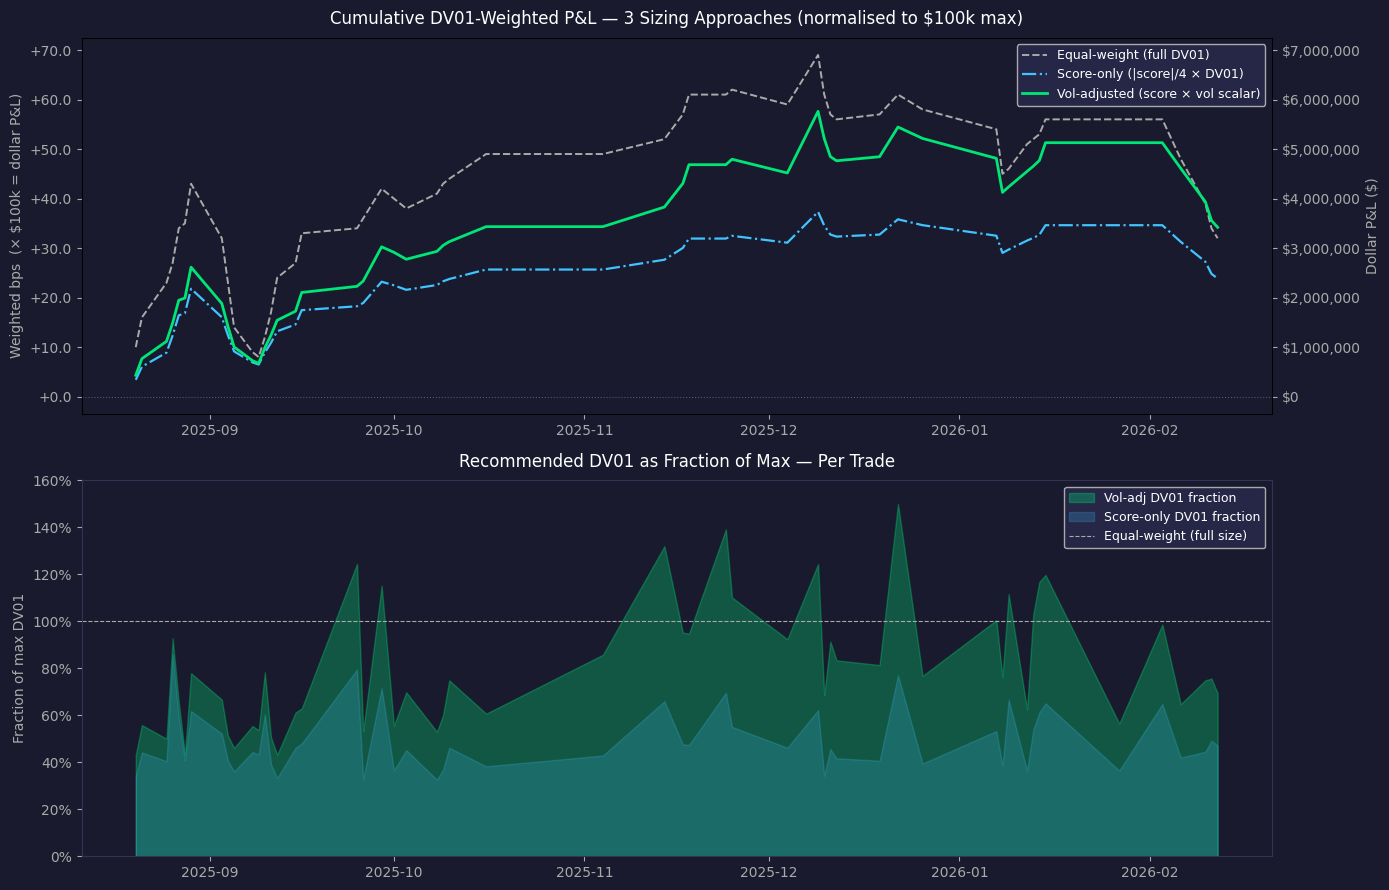


Final cumulative P&L (normalised bps):
  Equal-weight:   +32.0 bps  (=$3,200,000)
  Score-only:     +23.9 bps  (=$2,385,800)
  Vol-adjusted:   +34.2 bps  (=$3,419,740)


In [70]:
# ── Cumulative P&L comparison chart ──────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 9), facecolor='#1a1a2e')
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

dates = pd.to_datetime(sz.index)

# Top panel: cumulative DV01-weighted bps (3 approaches)
ax1 = axes[0]
cum_equal  = sz['pnl_equal_bps'].cumsum()
cum_score  = sz['pnl_score_bps'].cumsum()
cum_voladj = sz['pnl_voladj_bps'].cumsum()

ax1.plot(dates, cum_equal.values,  color='#aaaaaa', linewidth=1.4, linestyle='--',  label='Equal-weight (full DV01)')
ax1.plot(dates, cum_score.values,  color='#40c4ff', linewidth=1.6, linestyle='-.',   label='Score-only (|score|/4 × DV01)')
ax1.plot(dates, cum_voladj.values, color='#00e676', linewidth=2.0,                   label='Vol-adjusted (score × vol scalar)')
ax1.axhline(0, color='#555577', linewidth=0.8, linestyle=':')
ax1.set_title('Cumulative DV01-Weighted P&L — 3 Sizing Approaches (normalised to $100k max)', color='white', fontsize=12, pad=10)
ax1.set_ylabel('Weighted bps  (× $100k = dollar P&L)', color='#aaaaaa')
ax1.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.1f'))

# Add dollar axis on right
ax1r = ax1.twinx()
ax1r.set_ylim(ax1.get_ylim()[0] * MAX_DV01, ax1.get_ylim()[1] * MAX_DV01)
ax1r.set_ylabel('Dollar P&L ($)', color='#aaaaaa')
ax1r.tick_params(colors='#aaaaaa')
ax1r.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Bottom panel: DV01 fraction over time (shows how sizing varies)
ax2 = axes[1]
ax2.fill_between(dates, sz['dv01_voladj'].values, alpha=0.3, color='#00e676', label='Vol-adj DV01 fraction')
ax2.fill_between(dates, sz['dv01_score'].values,  alpha=0.2, color='#40c4ff', label='Score-only DV01 fraction')
ax2.axhline(1.0, color='#aaaaaa', linewidth=0.8, linestyle='--', label='Equal-weight (full size)')
ax2.set_title('Recommended DV01 as Fraction of Max — Per Trade', color='white', fontsize=12, pad=10)
ax2.set_ylabel('Fraction of max DV01', color='#aaaaaa')
ax2.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax2.set_ylim(0, 1.6)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()

# Print final totals
print(f'\nFinal cumulative P&L (normalised bps):')
print(f'  Equal-weight:   {cum_equal.iloc[-1]:+.1f} bps  (=${cum_equal.iloc[-1]*MAX_DV01:,.0f})')
print(f'  Score-only:     {cum_score.iloc[-1]:+.1f} bps  (=${cum_score.iloc[-1]*MAX_DV01:,.0f})')
print(f'  Vol-adjusted:   {cum_voladj.iloc[-1]:+.1f} bps  (=${cum_voladj.iloc[-1]*MAX_DV01:,.0f})')

---
## Overlapping Trades — True Independent Sharpe

The model signals daily but holds for 5 days. Every daily signal shares 4/5 of its
forward return window with the previous signal — so consecutive P&L observations are
not independent. The walk-forward Sharpe of ~2.04 is therefore slightly inflated.

Three ways to measure the real edge:

| Method | What it answers |
|--------|----------------|
| **Overlapping daily (current)** | Q5 bucket Sharpe — inflated by autocorrelation |
| **Non-overlapping (every 5d)** | True independent-trade Sharpe — most conservative |
| **Portfolio daily P&L** | What the equity curve actually looks like running this live |

In [71]:
# ── Non-overlapping: sample every HORIZON days ───────────────────────────────
nop     = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
nop_dir = nop[nop['direction'] != 'flat']

def sharpe_nop(s, h=HORIZON):
    return s.mean() / s.std() * np.sqrt(252 / h) if s.std() > 0 else np.nan

# ── Portfolio daily P&L: all concurrent positions summed ─────────────────────
port_pnl = SignalEngine.portfolio_pnl(df, horizon=HORIZON, max_dv01=MAX_DV01, target_risk_bps=10.0)
port_sharpe = port_pnl.mean() / port_pnl.std() * np.sqrt(252) if port_pnl.std() > 0 else np.nan
port_maxdd  = (port_pnl.cumsum() - port_pnl.cumsum().cummax()).min()

# ── Overlapping Q5 Sharpe (current metric) for comparison ────────────────────
sz_dir = sz[sz['direction'] != 'flat']   # from the DV01 sizing cells above
overlap_sharpe = sharpe_nop(sz_dir['aligned_bps'])

# ── Print comparison ──────────────────────────────────────────────────────────
print('=== Sharpe comparison (full history, 5d horizon) ===')
print()
print(f'  {"Method":<40}  {"Sharpe":>8}  {"Hit Rate":>9}  {"Mean bps":>9}  {"N obs":>6}')
print('  ' + '-'*78)
print(f'  {"Overlapping daily  (Q5/Q1 bucket)":<40}  {overlap_sharpe:>8.3f}  '
      f'{"":>9}  {"":>9}  {"(biased)":>6}')
print(f'  {"Non-overlapping  (every 5d sample)":<40}  {sharpe_nop(nop_dir["aligned_bps"]):>8.3f}  '
      f'{nop_dir["hit"].mean():>9.1%}  {nop_dir["aligned_bps"].mean():>+9.3f}  {len(nop_dir):>6}')
print(f'  {"Portfolio daily P&L  (concurrent pos.)":<40}  {port_sharpe:>8.3f}  '
      f'{"":>9}  {"":>9}  {"(daily)":>6}')
print()
overlap_inflation = (overlap_sharpe / sharpe_nop(nop_dir['aligned_bps']) - 1)
print(f'  Overlap inflation: {overlap_inflation:.0%}  '
      f'({overlap_sharpe:.3f} → {sharpe_nop(nop_dir["aligned_bps"]):.3f})')

=== Sharpe comparison (full history, 5d horizon) ===

  Method                                      Sharpe   Hit Rate   Mean bps   N obs
  ------------------------------------------------------------------------------
  Overlapping daily  (Q5/Q1 bucket)            0.825                        (biased)
  Non-overlapping  (every 5d sample)           1.393      60.3%     +1.699     146
  Portfolio daily P&L  (concurrent pos.)       1.510                        (daily)

  Overlap inflation: -41%  (0.825 → 1.393)


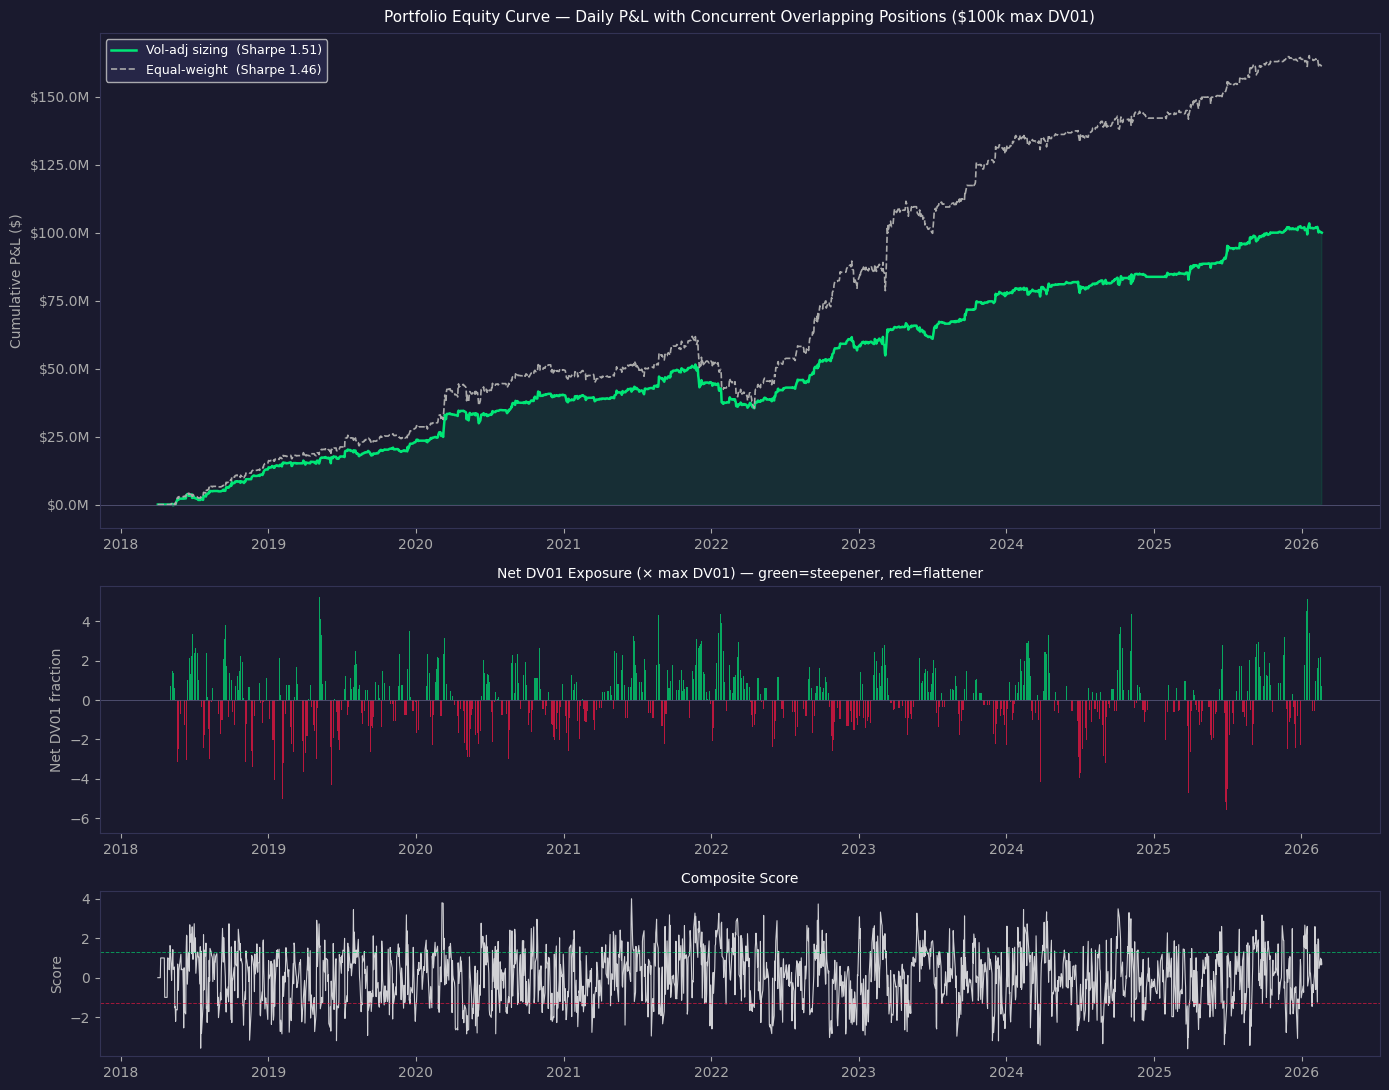


Portfolio stats (vol-adjusted sizing):
  Equal-weight Sharpe:   1.465
  Vol-adj Sharpe:        1.510
  Max drawdown (vol-adj): $-16,101,505


In [72]:
# ── Portfolio equity curve + concurrent position count ───────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 11), facecolor='#1a1a2e',
                          gridspec_kw={'height_ratios': [3, 1.5, 1]})
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

# ── Panel 1: portfolio cumulative P&L vs equal-weight daily ──────────────────
ax1 = axes[0]
cum_port = (port_pnl * MAX_DV01).cumsum()   # dollar cumulative P&L

# Equal-weight daily for comparison: full DV01 on every Q5/Q1 day
score_all = SignalEngine.composite_score(df)
chg_all   = df['2s10s_chg'].reindex(port_pnl.index).fillna(0)
sign_all  = pd.Series(0.0, index=port_pnl.index)
sign_all[score_all.reindex(port_pnl.index) >= 1.3]  = +1
sign_all[score_all.reindex(port_pnl.index) <= -1.3] = -1
# Each equal-weight "position" held for HORIZON days
ew_port = pd.Series(0.0, index=port_pnl.index)
for i, (date, sgn) in enumerate(sign_all.items()):
    if sgn == 0: continue
    future = port_pnl.index[i+1:i+1+HORIZON]
    for fd in future:
        ew_port[fd] += sgn * chg_all.get(fd, 0)
cum_ew = (ew_port * MAX_DV01).cumsum()

ax1.plot(port_pnl.index, cum_port.values, color='#00e676', linewidth=1.8,
         label=f'Vol-adj sizing  (Sharpe {port_sharpe:.2f})')
ax1.plot(ew_port.index, cum_ew.values, color='#aaaaaa', linewidth=1.2, linestyle='--',
         label=f'Equal-weight  (Sharpe {(ew_port.mean()/ew_port.std()*np.sqrt(252)):.2f})')
ax1.axhline(0, color='#555577', linewidth=0.6)
ax1.fill_between(port_pnl.index, cum_port.values, 0,
                 where=cum_port.values >= 0, alpha=0.1, color='#00e676')
ax1.set_title('Portfolio Equity Curve — Daily P&L with Concurrent Overlapping Positions ($100k max DV01)',
              color='white', fontsize=11, pad=8)
ax1.set_ylabel('Cumulative P&L ($)', color='#aaaaaa')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
ax1.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)

# ── Panel 2: concurrent open positions (net DV01 as multiple of max_dv01) ────
ax2 = axes[1]
# Count concurrent open positions weighted by DV01 fraction and sign
net_dv01 = pd.Series(0.0, index=port_pnl.index)
sizing_all = SignalEngine.position_size(df, max_dv01=MAX_DV01)
for i, (date, row) in enumerate(sizing_all.iterrows()):
    if row['direction'] == 'flat': continue
    sign = +1 if row['direction'] == 'steepener' else -1
    dv01_frac = float(row['recommended_dv01']) / MAX_DV01
    future = sizing_all.index[i+1:i+1+HORIZON]
    for fd in future:
        if fd in net_dv01.index:
            net_dv01[fd] += sign * dv01_frac

colors_dv01 = ['#00e676' if v >= 0 else '#ff1744' for v in net_dv01.values]
ax2.bar(net_dv01.index, net_dv01.values, color=colors_dv01, width=1, alpha=0.7)
ax2.axhline(0, color='#555577', linewidth=0.6)
ax2.set_title('Net DV01 Exposure (× max DV01) — green=steepener, red=flattener',
              color='white', fontsize=10, pad=6)
ax2.set_ylabel('Net DV01 fraction', color='#aaaaaa')

# ── Panel 3: composite score ──────────────────────────────────────────────────
ax3 = axes[2]
sc = SignalEngine.composite_score(df).reindex(port_pnl.index)
ax3.plot(sc.index, sc.values, color='white', linewidth=0.8, alpha=0.8)
ax3.axhline(1.3,  color='#00e676', linewidth=0.7, linestyle='--', alpha=0.6)
ax3.axhline(-1.3, color='#ff1744', linewidth=0.7, linestyle='--', alpha=0.6)
ax3.set_ylabel('Score', color='#aaaaaa')
ax3.set_title('Composite Score', color='white', fontsize=10, pad=6)

plt.tight_layout()
plt.show()

print(f'\nPortfolio stats (vol-adjusted sizing):')
ew_ann = ew_port.mean() / ew_port.std() * np.sqrt(252)
print(f'  Equal-weight Sharpe:   {ew_ann:.3f}')
print(f'  Vol-adj Sharpe:        {port_sharpe:.3f}')
print(f'  Max drawdown (vol-adj): ${port_maxdd * MAX_DV01:,.0f}')

---
## Carry & Roll — Trade Economics

For a **DV01-neutral 2s10s steepener** (long 10Y / short 2Y, 5-day hold):

| Component | Formula | Positive = |
|-----------|---------|------------|
| **Carry** | `[(y10 − SOFR)/dur10 − (y2 − SOFR)/dur2] × 5/252 × 100` | 10Y yield premium exceeds 2Y |
| **Roll** | `[(slope_10Y − slope_2Y)] × 5/252 × 100` | 10Y slopes steeper locally than 2Y |

`slope_10Y = (y10 − y5) / 5`  ·  `slope_2Y = 1y2y`  ·  Durations: 10Y ≈ 8.5yr, 2Y ≈ 1.9yr

**For a flattener, all signs flip.** C+R is applied to each trade in `non_overlapping_performance()` and accrued daily in `portfolio_pnl()`.

In [ ]:
# ── Carry & roll — always recompute from raw columns ─────────────────────────
# Compute directly so this cell works regardless of when the kernel was started.
# Uses SOFR when available (post-Apr 2018), Fed Funds otherwise — same logic
# as FeatureEngineer Block 9.
_DUR_10Y, _DUR_2Y, _H = 8.5, 1.9, 5

_repo        = df["SOFR"].fillna(df["Fed_Funds"])
_carry_ann   = (df["10Y"] - _repo) / _DUR_10Y - (df["2Y"] - _repo) / _DUR_2Y
df["carry_5d"]    = _carry_ann * 100 * _H / 252

_slope_10Y        = (df["10Y"] - df["5Y"]) / 5
_slope_2Y         = df["1y2y"]
df["roll_5d"]       = (_slope_10Y - _slope_2Y) * 100 * _H / 252
df["carry_roll_5d"] = df["carry_5d"] + df["roll_5d"]

# ── Current snapshot ──────────────────────────────────────────────────────────
last_row = df.iloc[-1]
sofr     = last_row["SOFR"]
carry_5d = last_row["carry_5d"]
roll_5d  = last_row["roll_5d"]
cr_5d    = last_row["carry_roll_5d"]

print(f'=== Current Carry & Roll ({df.index[-1].date()}) ===')
print(f'  Repo (SOFR):              {sofr:.2f}%')
print(f'  Carry (steepener, 5d):   {carry_5d:+.3f} bps')
print(f'  Roll  (steepener, 5d):   {roll_5d:+.3f} bps')
print(f'  Carry + Roll (5d):       {cr_5d:+.3f} bps')
print(f'  C+R annualised:          {cr_5d * 252 / 5:+.1f} bps/yr')
print()

# Full-history statistics
cr_hist = df['carry_roll_5d'].dropna()
print(f'=== Full-history carry+roll ({cr_hist.index[0].date()} – {cr_hist.index[-1].date()}) ===')
print(f'  Mean:     {cr_hist.mean():+.3f}   Median: {cr_hist.median():+.3f}')
print(f'  Std:      {cr_hist.std():.3f}')
print(f'  Min:      {cr_hist.min():+.3f}   Max: {cr_hist.max():+.3f}')
print(f'  % positive (steepener earns C+R): {(cr_hist > 0).mean():.1%}')
print()

# C+R breakdown by signal direction in non-overlapping sample
_nop2 = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
steep = _nop2[_nop2['direction'] == 'steepener']['carry_roll_bps'].dropna()
flat  = _nop2[_nop2['direction'] == 'flattener']['carry_roll_bps'].dropna()
print('=== C+R by trade direction (non-overlapping signals) ===')
print(f'  Steepener signals:  n={len(steep):3d}  mean C+R = {steep.mean():+.3f} bps')
print(f'  Flattener signals:  n={len(flat):3d}  mean C+R = {flat.mean():+.3f} bps')
print(f'  (Flattener C+R = negative of steepener — shows C+R tilt of the signal)')

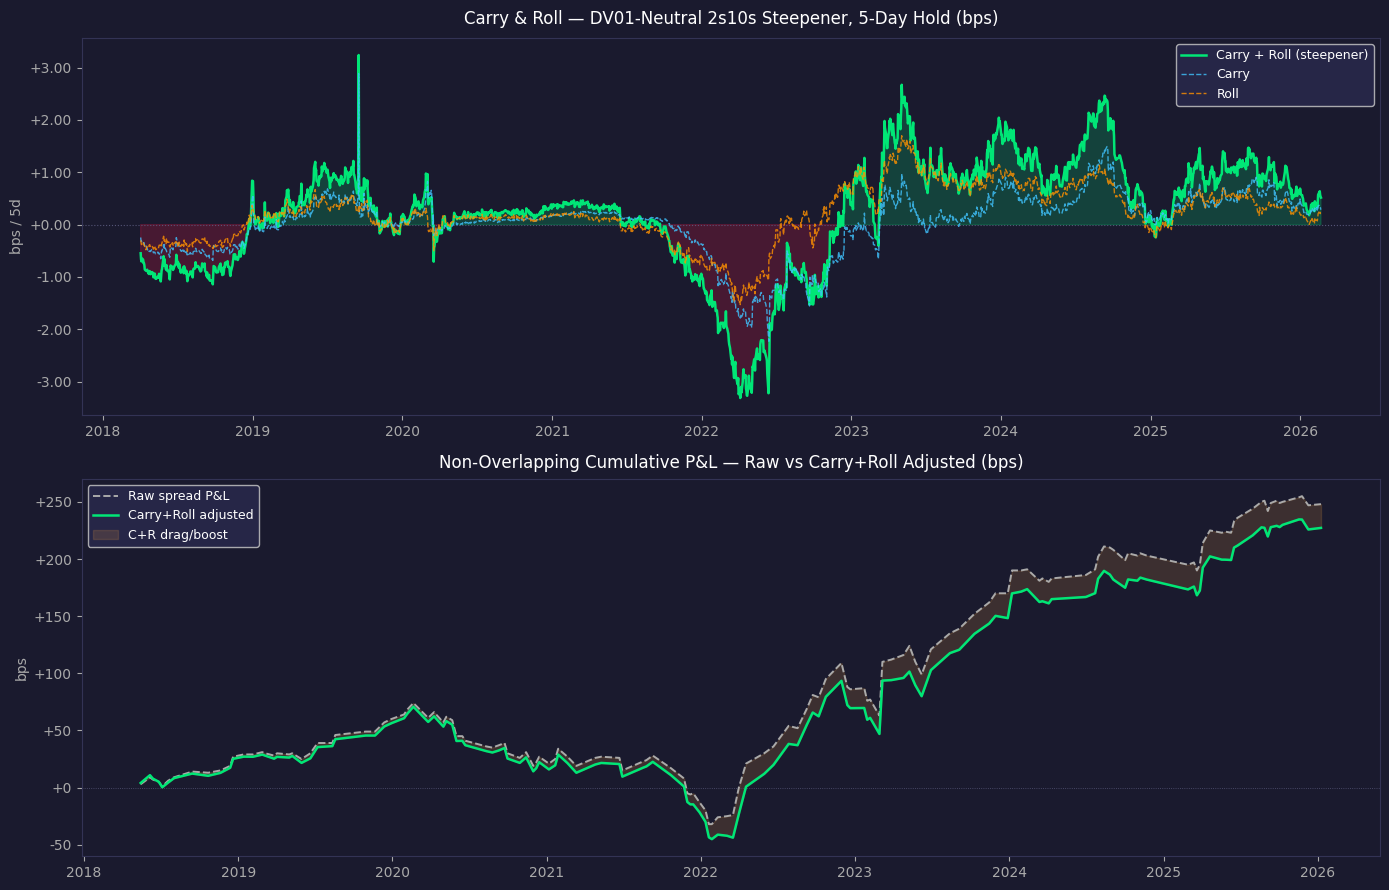

In [76]:
# ── Carry & roll chart ────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 9), facecolor='#1a1a2e')
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

# Panel 1: carry, roll, total C+R over time
ax1 = axes[0]
cr_ts = df[['carry_5d', 'roll_5d', 'carry_roll_5d']].dropna()
ax1.axhline(0, color='#555577', linewidth=0.8, linestyle=':')
ax1.fill_between(cr_ts.index, cr_ts['carry_roll_5d'], 0,
                 where=cr_ts['carry_roll_5d'] >= 0, alpha=0.20, color='#00e676')
ax1.fill_between(cr_ts.index, cr_ts['carry_roll_5d'], 0,
                 where=cr_ts['carry_roll_5d'] < 0,  alpha=0.20, color='#ff1744')
ax1.plot(cr_ts.index, cr_ts['carry_roll_5d'], color='#00e676', linewidth=1.8,
         label='Carry + Roll (steepener)')
ax1.plot(cr_ts.index, cr_ts['carry_5d'],      color='#40c4ff', linewidth=1.0,
         linestyle='--', alpha=0.8, label='Carry')
ax1.plot(cr_ts.index, cr_ts['roll_5d'],       color='#ff9100', linewidth=1.0,
         linestyle='--', alpha=0.8, label='Roll')
ax1.set_title('Carry & Roll — DV01-Neutral 2s10s Steepener, 5-Day Hold (bps)',
              color='white', fontsize=12, pad=10)
ax1.set_ylabel('bps / 5d', color='#aaaaaa')
ax1.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.2f'))

# Panel 2: cumulative P&L — raw vs carry-adjusted (non-overlapping directional)
ax2 = axes[1]
_nop = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
_dir = _nop[_nop['direction'] != 'flat']
cum_raw_cr = _dir['aligned_bps'].cumsum()
cum_adj_cr = _dir['aligned_adj_bps'].dropna().cumsum()

ax2.axhline(0, color='#555577', linewidth=0.6, linestyle=':')
ax2.plot(pd.to_datetime(cum_raw_cr.index), cum_raw_cr.values,
         color='#aaaaaa', linewidth=1.4, linestyle='--', label='Raw spread P&L')
ax2.plot(pd.to_datetime(cum_adj_cr.index), cum_adj_cr.values,
         color='#00e676', linewidth=1.8, label='Carry+Roll adjusted')
ax2.fill_between(pd.to_datetime(cum_adj_cr.index), cum_adj_cr.values, cum_raw_cr.reindex(cum_adj_cr.index).values,
                 alpha=0.15, color='#ffab40', label='C+R drag/boost')
ax2.set_title('Non-Overlapping Cumulative P&L — Raw vs Carry+Roll Adjusted (bps)',
              color='white', fontsize=12, pad=8)
ax2.set_ylabel('bps', color='#aaaaaa')
ax2.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.0f'))

plt.tight_layout()
plt.show()

In [77]:
# ── Carry-adjusted Sharpe comparison ─────────────────────────────────────────
nop_cr  = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
nop_dir_cr = nop_cr[nop_cr['direction'] != 'flat']

def _s(s):
    s = s.dropna()
    return s.mean() / s.std() * np.sqrt(252 / HORIZON) if len(s) > 1 and s.std() > 0 else np.nan

raw_sharpe = _s(nop_dir_cr['aligned_bps'])
adj_sharpe = _s(nop_dir_cr['aligned_adj_bps'])
raw_hit    = nop_dir_cr['hit'].mean()
adj_hit    = nop_dir_cr['hit_adj'].mean()
raw_mean   = nop_dir_cr['aligned_bps'].mean()
adj_mean   = nop_dir_cr['aligned_adj_bps'].dropna().mean()
cr_mean    = nop_dir_cr['carry_roll_bps'].dropna().mean()
cr_total   = nop_dir_cr['carry_roll_bps'].dropna().sum()

print('=== Non-overlapping Sharpe: Raw vs Carry+Roll Adjusted ===')
print()
print(f'  {"Metric":<36}  {"Raw":>9}  {"C+R Adj":>9}  {"Delta":>8}')
print('  ' + '─' * 68)
print(f'  {"Sharpe (ann.)":<36}  {raw_sharpe:>+9.3f}  {adj_sharpe:>+9.3f}  {adj_sharpe - raw_sharpe:>+8.3f}')
print(f'  {"Hit rate":<36}  {raw_hit:>9.1%}  {adj_hit:>9.1%}  {adj_hit - raw_hit:>+8.1%}')
print(f'  {"Mean trade P&L (bps)":<36}  {raw_mean:>+9.3f}  {adj_mean:>+9.3f}  {adj_mean - raw_mean:>+8.3f}')
print(f'  {"Mean C+R contribution (bps)":<36}  {"—":>9}  {cr_mean:>+9.3f}  {"":>8}')
print(f'  {"Total C+R over full history (bps)":<36}  {"—":>9}  {cr_total:>+9.1f}  {"":>8}')
print()
print(f'  N directional signals: {len(nop_dir_cr)}  (of {len(nop_cr)} independent windows)')
pct_impact = (adj_sharpe / raw_sharpe - 1) * 100 if raw_sharpe != 0 else np.nan
print(f'  C+R impact on Sharpe: {pct_impact:+.1f}%')

=== Non-overlapping Sharpe: Raw vs Carry+Roll Adjusted ===

  Metric                                      Raw    C+R Adj     Delta
  ────────────────────────────────────────────────────────────────────
  Sharpe (ann.)                            +1.393     +1.253    -0.140
  Hit rate                                  60.3%      56.8%     -3.4%
  Mean trade P&L (bps)                     +1.699     +1.556    -0.142
  Mean C+R contribution (bps)                   —     -0.142          
  Total C+R over full history (bps)             —      -20.8          

  N directional signals: 146  (of 393 independent windows)
  C+R impact on Sharpe: -10.1%


---
## Carry & Roll — Repo-Financed 2s10s Trade Economics

Carry and roll are the two holding-period components of a DV01-neutral 2s10s trade that
exist regardless of whether the spread moves. Including them gives the **true all-in P&L**.

| Component | Formula (steepener) |
|-----------|---------------------|
| **Carry** | `[(y10 − SOFR) / dur10 − (y2 − SOFR) / dur2] × 100 × 5/252` |
| **Roll**  | `[(slope_10Y) − (slope_2Y)] × 100 × 5/252`                   |
| **Total** | Carry + Roll (bps per 5-day hold)                             |

- `dur10 ≈ 8.5 yr`, `dur2 ≈ 1.9 yr` (approximate modified duration for ~par bonds)  
- `slope_10Y = (10Y − 5Y) / 5`, `slope_2Y = 1y2y`  
- Convention: **positive = steepener earns**, negative = steepener pays; flip sign for flattener.
- Repo rate = SOFR (GC repo benchmark, already loaded in DataLoader).

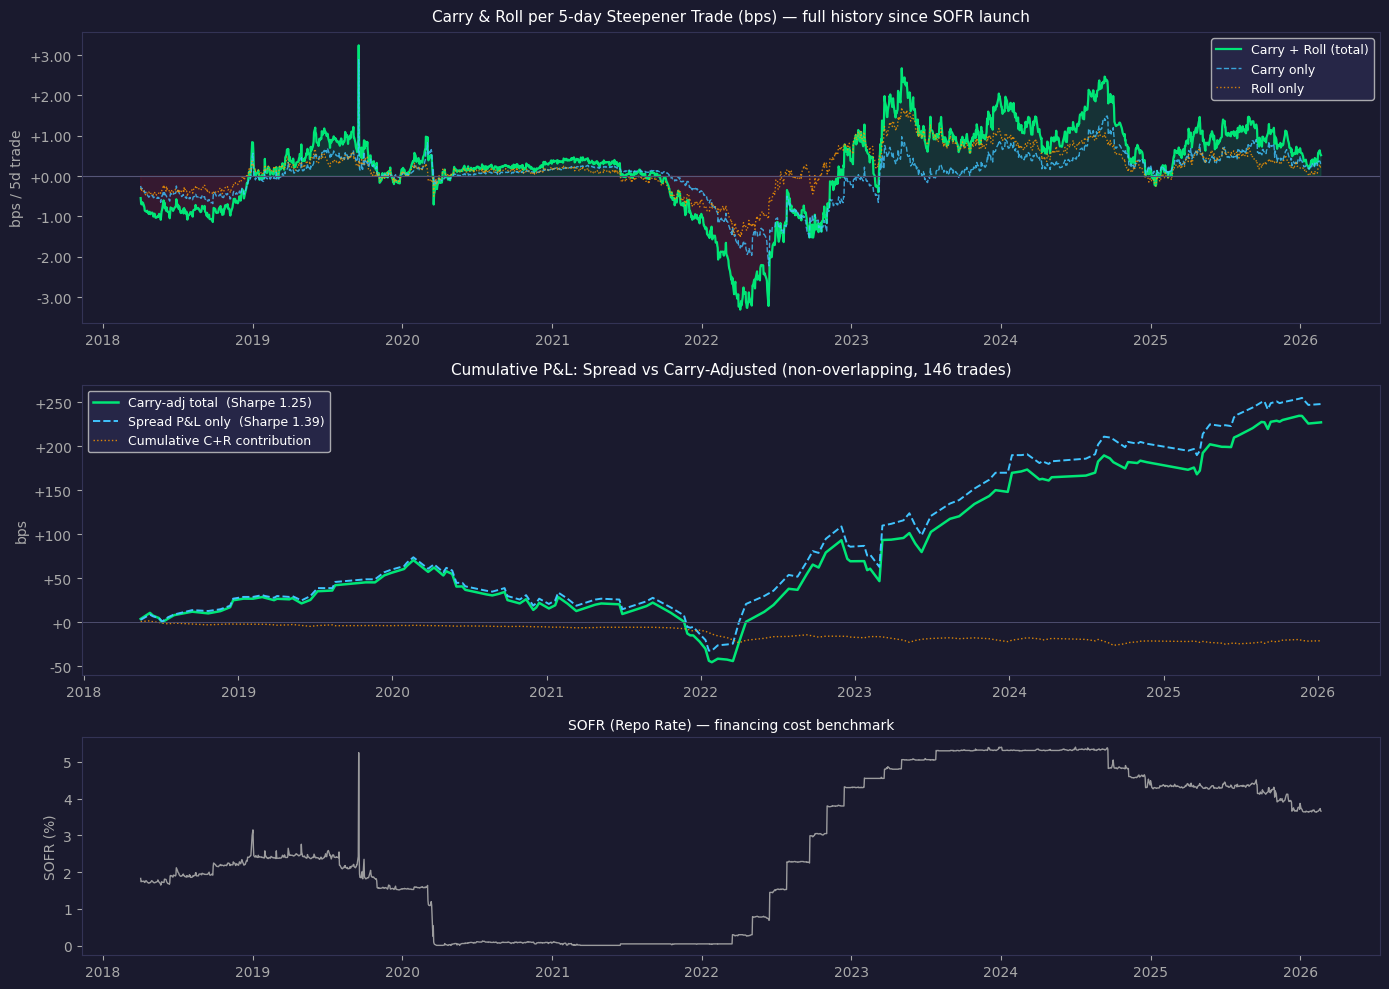


Carry+roll context:
  Current C+R (steepener, 5d):  +0.516 bps
  Current carry component:       +0.286 bps
  Current roll component:        +0.230 bps
  Current SOFR:                  3.66%

  Annualised C+R (steepener book at 50 trades/yr):  +25.8 bps/yr


In [78]:
# ── Carry+roll history chart ──────────────────────────────────────────────────
# Compute non-overlapping sample with carry adjustment (used in panels below)
_nop_chart = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
nop_cr_dir  = _nop_chart[_nop_chart['direction'] != 'flat'].dropna(subset=['aligned_adj_bps'])

def _sharpe_cr(s, h=HORIZON):
    return s.mean() / s.std() * np.sqrt(252 / h) if len(s) > 1 and s.std() > 0 else np.nan

raw_sharpe = _sharpe_cr(nop_cr_dir['aligned_bps'])
adj_sharpe = _sharpe_cr(nop_cr_dir['aligned_adj_bps'])

fig, axes = plt.subplots(3, 1, figsize=(14, 10), facecolor='#1a1a2e',
                          gridspec_kw={'height_ratios': [2, 2, 1.5]})
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

# ── Panel 1: carry+roll and sub-components over full history ──────────────────
ax1 = axes[0]
cr_full = df[['carry_5d', 'roll_5d', 'carry_roll_5d']].dropna()
ax1.plot(cr_full.index, cr_full['carry_roll_5d'].values, color='#00e676', linewidth=1.6,
         label='Carry + Roll (total)')
ax1.plot(cr_full.index, cr_full['carry_5d'].values, color='#40c4ff', linewidth=1.0,
         linestyle='--', alpha=0.8, label='Carry only')
ax1.plot(cr_full.index, cr_full['roll_5d'].values, color='#ff9800', linewidth=1.0,
         linestyle=':', alpha=0.8, label='Roll only')
ax1.axhline(0, color='#555577', linewidth=0.8)
ax1.fill_between(cr_full.index, cr_full['carry_roll_5d'].values, 0,
                 where=cr_full['carry_roll_5d'].values >= 0, alpha=0.12, color='#00e676')
ax1.fill_between(cr_full.index, cr_full['carry_roll_5d'].values, 0,
                 where=cr_full['carry_roll_5d'].values < 0,  alpha=0.12, color='#ff1744')
ax1.set_title('Carry & Roll per 5-day Steepener Trade (bps) — full history since SOFR launch',
              color='white', fontsize=11, pad=8)
ax1.set_ylabel('bps / 5d trade', color='#aaaaaa')
ax1.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.2f'))

# ── Panel 2: cumulative carry+roll vs spread P&L (trade-signed, non-overlapping) ─
ax2 = axes[1]
cum_raw_nop = nop_cr_dir['aligned_bps'].cumsum()
cum_adj_nop = nop_cr_dir['aligned_adj_bps'].cumsum()
cum_cr_only = nop_cr_dir['carry_roll_bps'].cumsum()

ax2.plot(pd.to_datetime(cum_adj_nop.index), cum_adj_nop.values,
         color='#00e676', linewidth=1.8, label=f'Carry-adj total  (Sharpe {adj_sharpe:.2f})')
ax2.plot(pd.to_datetime(cum_raw_nop.index), cum_raw_nop.values,
         color='#40c4ff', linewidth=1.4, linestyle='--', label=f'Spread P&L only  (Sharpe {raw_sharpe:.2f})')
ax2.plot(pd.to_datetime(cum_cr_only.index), cum_cr_only.values,
         color='#ff9800', linewidth=1.0, linestyle=':', alpha=0.85, label='Cumulative C+R contribution')
ax2.axhline(0, color='#555577', linewidth=0.6)
ax2.set_title(f'Cumulative P&L: Spread vs Carry-Adjusted (non-overlapping, {len(nop_cr_dir)} trades)',
              color='white', fontsize=11, pad=8)
ax2.set_ylabel('bps', color='#aaaaaa')
ax2.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%+.0f'))

# ── Panel 3: SOFR (repo rate) over time ──────────────────────────────────────
ax3 = axes[2]
sofr_s = df['SOFR'].dropna()
ax3.plot(sofr_s.index, sofr_s.values, color='#aaaaaa', linewidth=1.0, alpha=0.9)
ax3.set_title('SOFR (Repo Rate) — financing cost benchmark', color='white', fontsize=10, pad=6)
ax3.set_ylabel('SOFR (%)', color='#aaaaaa')

plt.tight_layout()
plt.show()

print(f'\nCarry+roll context:')
print(f'  Current C+R (steepener, 5d):  {df["carry_roll_5d"].iloc[-1]:+.3f} bps')
print(f'  Current carry component:       {df["carry_5d"].iloc[-1]:+.3f} bps')
print(f'  Current roll component:        {df["roll_5d"].iloc[-1]:+.3f} bps')
print(f'  Current SOFR:                  {df["SOFR"].iloc[-1]:.2f}%')
print()
print(f'  Annualised C+R (steepener book at 50 trades/yr):  {df["carry_roll_5d"].iloc[-1] * 50:+.1f} bps/yr')

In [79]:
# ── Carry+roll history and carry-adjusted Sharpe ─────────────────────────────
# Non-overlapping trades (every 5d) with carry+roll baked in
nop_cr = SignalEngine.non_overlapping_performance(df, horizon=HORIZON)
nop_cr_dir = nop_cr[nop_cr['direction'] != 'flat'].dropna(subset=['aligned_adj_bps'])

def sharpe_cr(s, h=HORIZON):
    return s.mean() / s.std() * np.sqrt(252 / h) if len(s) > 1 and s.std() > 0 else np.nan

# ── Current carry+roll snapshot ───────────────────────────────────────────────
cr_last = df[['carry_5d', 'roll_5d', 'carry_roll_5d', 'SOFR']].tail(10)
print('=== Carry & Roll — last 10 trading days ===')
print(cr_last.to_string(float_format=lambda x: f'{x:+.3f}'))
print()

# ── Summary: carry+roll contribution over full history ────────────────────────
cr_steepener = nop_cr_dir['carry_roll_bps']
print(f'Mean carry+roll per trade (signed for direction): {cr_steepener.mean():+.3f} bps')
print(f'Total cumulative carry+roll (full history):       {cr_steepener.sum():+.1f} bps')
print(f'Ann. carry+roll drag/boost at 252/5=50 trades/yr: {cr_steepener.mean() * 252/HORIZON:+.1f} bps/yr')
print()

# ── Sharpe comparison: raw vs carry-adjusted ──────────────────────────────────
raw_sharpe = sharpe_cr(nop_cr_dir['aligned_bps'])
adj_sharpe = sharpe_cr(nop_cr_dir['aligned_adj_bps'])

print('=== Non-overlapping Sharpe: raw spread P&L vs carry-adjusted ===')
print()
print(f'  {"Metric":<40}   {"Raw":>8}   {"Carry-adj":>10}   {"Delta":>8}')
print('  ' + '-'*72)
print(f'  {"Sharpe (5d non-overlapping)":<40}   {raw_sharpe:>8.3f}   {adj_sharpe:>10.3f}   {adj_sharpe-raw_sharpe:>+8.3f}')
print(f'  {"Mean bps per trade":<40}   {nop_cr_dir["aligned_bps"].mean():>+8.3f}   '
      f'{nop_cr_dir["aligned_adj_bps"].mean():>+10.3f}   '
      f'{nop_cr_dir["aligned_adj_bps"].mean()-nop_cr_dir["aligned_bps"].mean():>+8.3f}')
print(f'  {"Hit rate":<40}   {nop_cr_dir["hit"].mean():>8.1%}   {nop_cr_dir["hit_adj"].mean():>10.1%}   '
      f'{"":>8}')
print(f'  {"N obs":<40}   {len(nop_cr_dir):>8}')
print()

# ── Portfolio Sharpe with carry accrual ───────────────────────────────────────
port_pnl_cr = SignalEngine.portfolio_pnl(df, horizon=HORIZON, max_dv01=MAX_DV01, target_risk_bps=10.0)
port_sharpe_cr = port_pnl_cr.mean() / port_pnl_cr.std() * np.sqrt(252) if port_pnl_cr.std() > 0 else np.nan
print(f'  {"Portfolio Sharpe (carry-adjusted)":<40}   {port_sharpe_cr:>8.3f}')

=== Carry & Roll — last 10 trading days ===
            carry_5d  roll_5d  carry_roll_5d   SOFR
2026-02-06    +0.282   +0.083         +0.365 +3.640
2026-02-09    +0.294   +0.087         +0.382 +3.630
2026-02-10    +0.328   +0.083         +0.411 +3.650
2026-02-11    +0.259   +0.071         +0.331 +3.650
2026-02-12    +0.291   +0.127         +0.418 +3.650
2026-02-13    +0.360   +0.210         +0.571 +3.660
2026-02-17    +0.372   +0.266         +0.638 +3.710
2026-02-18    +0.356   +0.210         +0.566 +3.730
2026-02-19    +0.305   +0.230         +0.535 +3.670
2026-02-20    +0.286   +0.230         +0.516 +3.660

Mean carry+roll per trade (signed for direction): -0.142 bps
Total cumulative carry+roll (full history):       -20.8 bps
Ann. carry+roll drag/boost at 252/5=50 trades/yr: -7.2 bps/yr

=== Non-overlapping Sharpe: raw spread P&L vs carry-adjusted ===

  Metric                                          Raw    Carry-adj      Delta
  -----------------------------------------------------